In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import publish_model_scores
from src.datasampling import dataSampling
from src.bayesianopt import bayesianOpt
from sklearn.tree import DecisionTreeClassifier

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

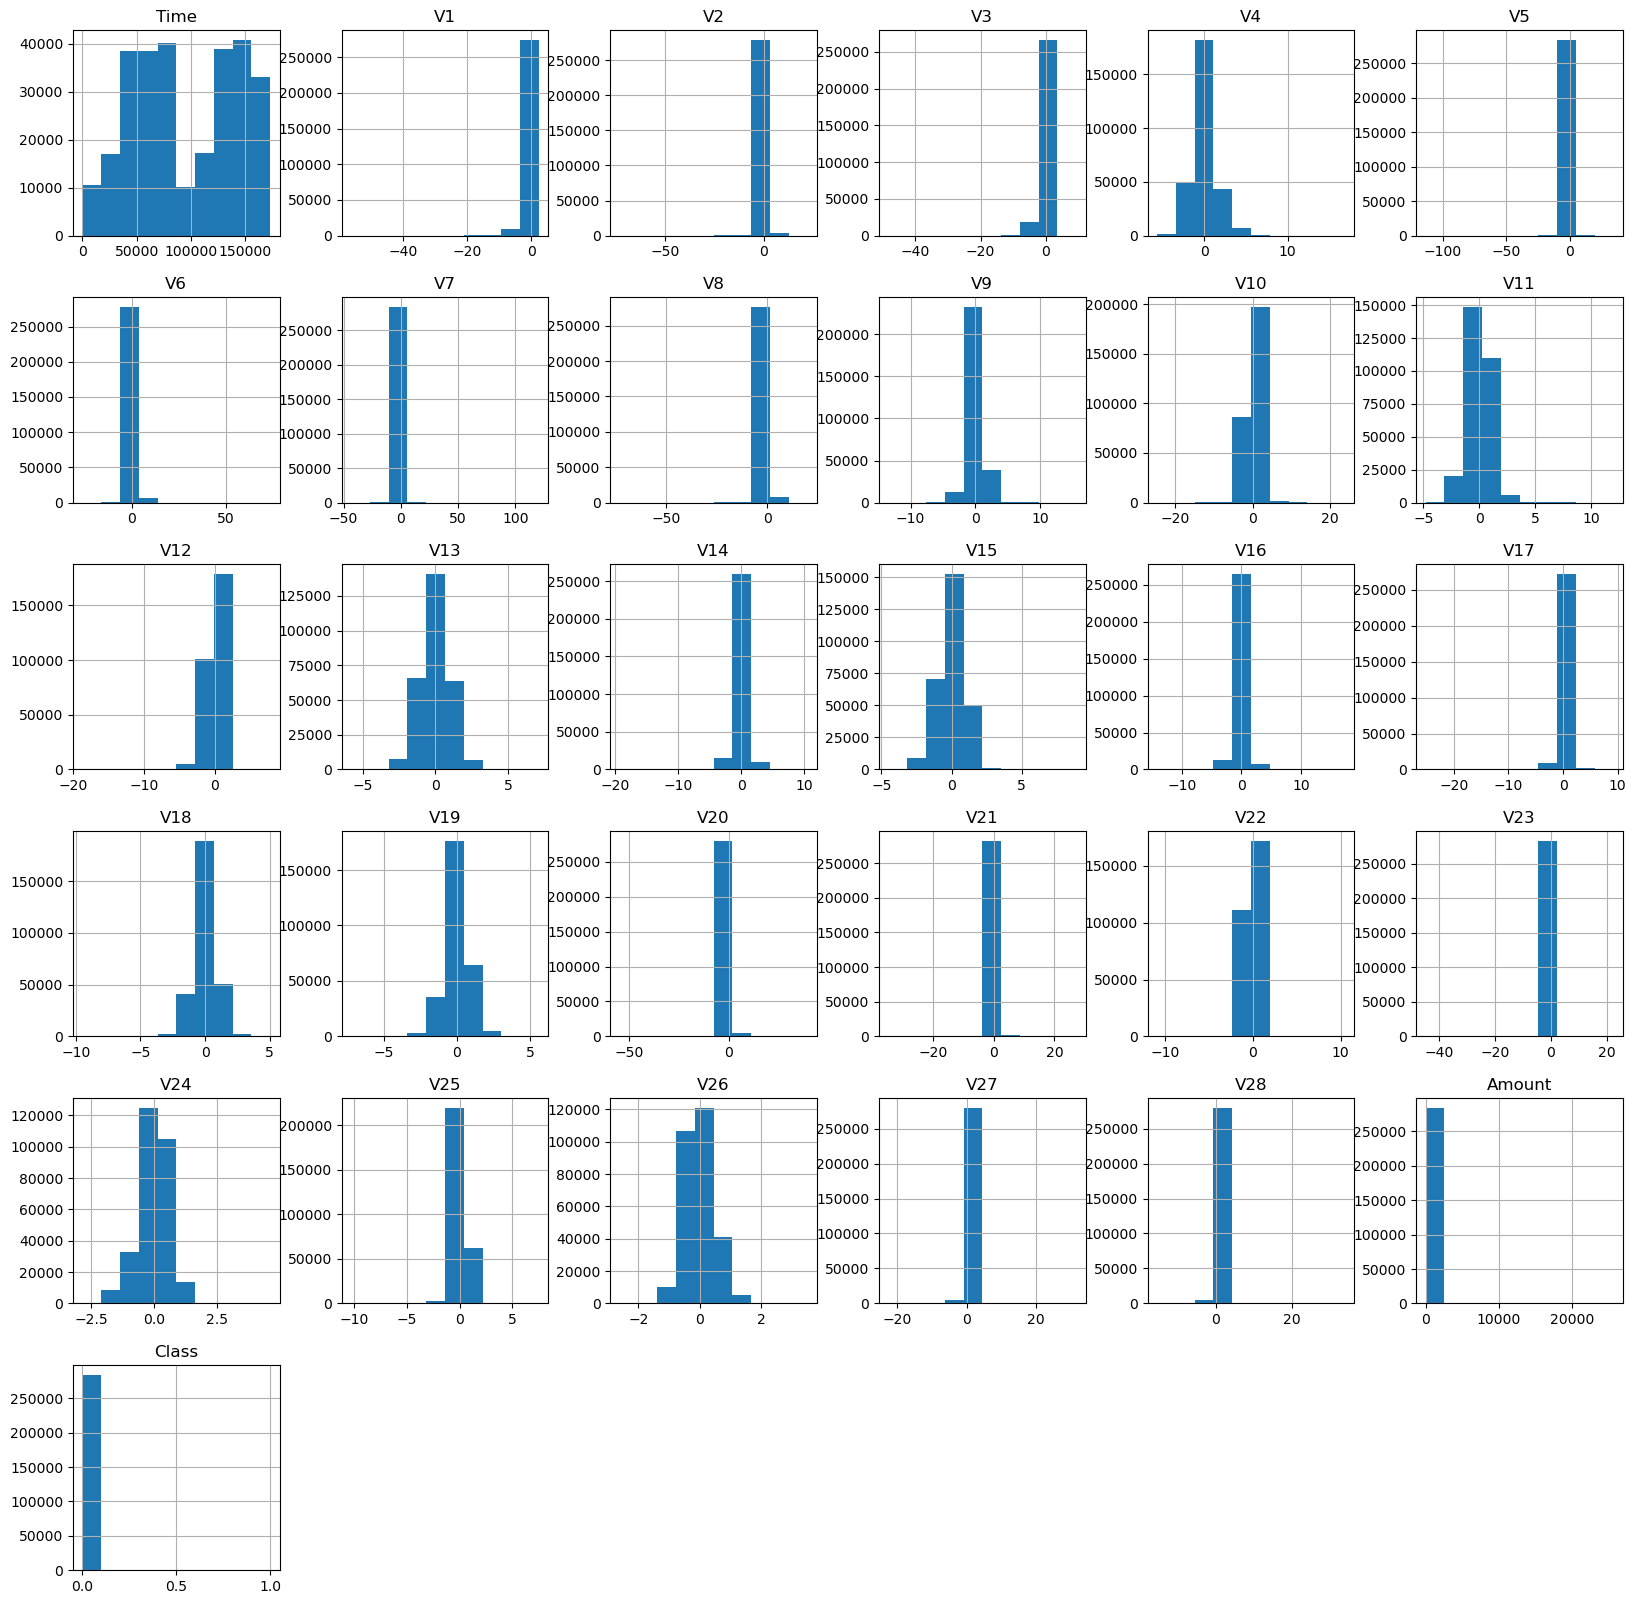

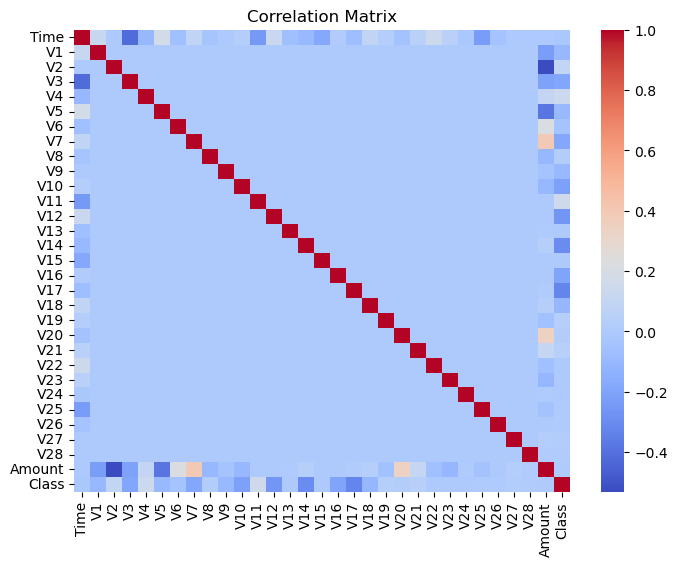

In [3]:
df = pd.read_csv("../creditcard.csv")
print(df.head(n=10))

# Plot the histogrm
df.hist(figsize = (20, 20))
plt.show()

# Comment : features are scaled so need not to do any standard transformation for preprocessing

# Print the correlation of data
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Comment : There is no significant correlation amoung the data so no need for reducing highly correlated data

# 1 Evaluate Desicion Tree Classifier without sampling techniques

# 1.1 Get the data

In [4]:
# Make a data source object using dataSampling class
ds = dataSampling(df,"Class",0.30,42,True,True)

In [5]:
# Make in-smaple and out sample dataset without sampling
X_train,X_test,y_train,y_test = ds.get_data_without_sample()
ds.print_class_percentage(X_train,X_test,y_train,y_test)

=====Train class count=====
Class
0    199020
1       344
Name: count, dtype: int64
Class
0    0.998275
1    0.001725
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 1.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [6]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_model = dt_opt.optimize_fit(X_train,y_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 1.3 See the performance on unseen data

In [7]:
dt_opt.optimize_results["best_params"]

{'class_weight': {0: 1, 1: 1},
 'criterion': 'entropy',
 'cv': 2,
 'max_depth': 5,
 'max_features': 'log2',
 'min_samples_split': 5,
 'n_jobs': -1,
 'scoring': 'f1_macro'}

In [8]:
print("------Training model Results------")
publish_model_scores(X_train,y_train,best_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199020
           1       0.93      0.78      0.85       344

    accuracy                           1.00    199364
   macro avg       0.96      0.89      0.92    199364
weighted avg       1.00      1.00      1.00    199364

ROC_AUC Score 0.9715353049711026
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.91      0.78      0.84       148

    accuracy                           1.00     85443
   macro avg       0.95      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443

ROC_AUC Score 0.9475456800959468


# 2. Evaluate using under sampling (near miss) method

# 2.1 Get the data

In [9]:
X_nm_train,X_test,y_nm_train,y_test= ds.get_data_near_miss()
ds.print_class_percentage(X_nm_train,X_test,y_nm_train,y_test)

=====Train class count=====
Class
0    3440
1     344
Name: count, dtype: int64
Class
0    0.909091
1    0.090909
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 2.2 Fit the Descion Tree Classifier and optimize Hyperparameters using Bayesian Optimization

In [10]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_nm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_nm_model = dt_nm_opt.optimize_fit(X_nm_train,y_nm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 2.3 See the performance on unseen data

In [11]:
print("------Training model Results------")
publish_model_scores(X_nm_train,y_nm_train,best_nm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_nm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3440
           1       0.97      0.88      0.92       344

    accuracy                           0.99      3784
   macro avg       0.98      0.94      0.96      3784
weighted avg       0.99      0.99      0.99      3784

ROC_AUC Score 0.9782631659004868
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.12      0.89      0.21       148

    accuracy                           0.99     85443
   macro avg       0.56      0.94      0.60     85443
weighted avg       1.00      0.99      0.99     85443

ROC_AUC Score 0.9679322399367538


# 3. Evaluate using over sampling (SMOTE) method
# 3.1 Get the data sets using SMOTE sampling technique

In [12]:
X_sm_train,X_test,y_sm_train,y_test= ds.get_data_smote()
ds.print_class_percentage(X_sm_train,X_test,y_sm_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 3.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [13]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_sm_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_sm_model = dt_sm_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 3.3 Evaluate the Performance

In [14]:
print("------Training model Results------")
publish_model_scores(X_sm_train,y_sm_train,best_sm_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_sm_model)

------Training model Results------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    199020
           1       0.99      1.00      1.00    199020

    accuracy                           1.00    398040
   macro avg       1.00      1.00      1.00    398040
weighted avg       1.00      1.00      1.00    398040

ROC_AUC Score 0.9998828788750538
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.19      0.85      0.31       148

    accuracy                           0.99     85443
   macro avg       0.59      0.92      0.65     85443
weighted avg       1.00      0.99      1.00     85443

ROC_AUC Score 0.9225892490767338


# 4 Evaluate Performance using Random Over Sampling Methods
# 4.1 Get the dataset using ramdom over sampling method

In [15]:
X_rn_train,X_test,y_rn_train,y_test= ds.get_data_random_over_sample()
ds.print_class_percentage(X_rn_train,X_test,y_rn_train,y_test)

=====Train class count=====
Class
0    199020
1    199020
Name: count, dtype: int64
Class
0    0.5
1    0.5
Name: count, dtype: float64

=====Test class count=====
Class
0    85295
1      148
Name: count, dtype: int64
Class
0    0.998268
1    0.001732
Name: count, dtype: float64


# 4.2 Fit the data and tune the hyperparametres using Bayesian Optimization

In [16]:
# Specified the parameters
param_grid = { 'criterion':['gini','entropy'],
              'max_depth': np.arange(1,15),
              "max_features": ['sqrt', 'log2'],
              "min_samples_split": range(2,21),
              "class_weight": [{0:1, 1:1}, {0:1, 1:5}, {0:1, 1:50},'balanced'],
              "cv":[2],"scoring":["f1_macro"],"n_jobs":[-1]}

# Config dict for Bayesian Optimizer
conf_dict={"num_iteration":100}

# Fit and Optimize the Baysian model
dt_rn_opt = bayesianOpt(DecisionTreeClassifier(random_state = 0))
best_rn_model = dt_rn_opt.optimize_fit(X_sm_train,y_sm_train,param_grid,conf_dict)

  0%|          | 0/100 [00:00<?, ?it/s]

# 4.3 Evaluate the Performance on unseen data

In [17]:
print("------Training model Results------")
publish_model_scores(X_rn_train,y_rn_train,best_rn_model)
print("------Testing model Result----------")
publish_model_scores(X_test,y_test,best_rn_model)

------Training model Results------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    199020
           1       0.99      0.99      0.99    199020

    accuracy                           0.99    398040
   macro avg       0.99      0.99      0.99    398040
weighted avg       0.99      0.99      0.99    398040

ROC_AUC Score 0.9996537866214736
------Testing model Result----------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.19      0.85      0.31       148

    accuracy                           0.99     85443
   macro avg       0.59      0.92      0.65     85443
weighted avg       1.00      0.99      1.00     85443

ROC_AUC Score 0.9225892490767338


## SUMMARY

Decision Tree Classifier:

No sampling test roc_auc: 0.9475

Near-miss under sampling test roc_auc: 0.9679

SMOTE over sampling test roc_auc: 0.9225

Random over sampling test roc_auc: 0.9225

## SHAP Analysis

For near miss undersmapled data:

In [32]:
import shap

In [33]:
clf = DecisionTreeClassifier()

clf.fit(X_nm_train, y_nm_train)

explainer = shap.Explainer(clf, X_nm_train)

shap_values = explainer(X_test)

In [34]:
explainer = shap.Explainer(clf, X_nm_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Indexing for the positive class SHAP values (which is typically at index 1)
positive_class_shap_values = shap_values[..., 1]

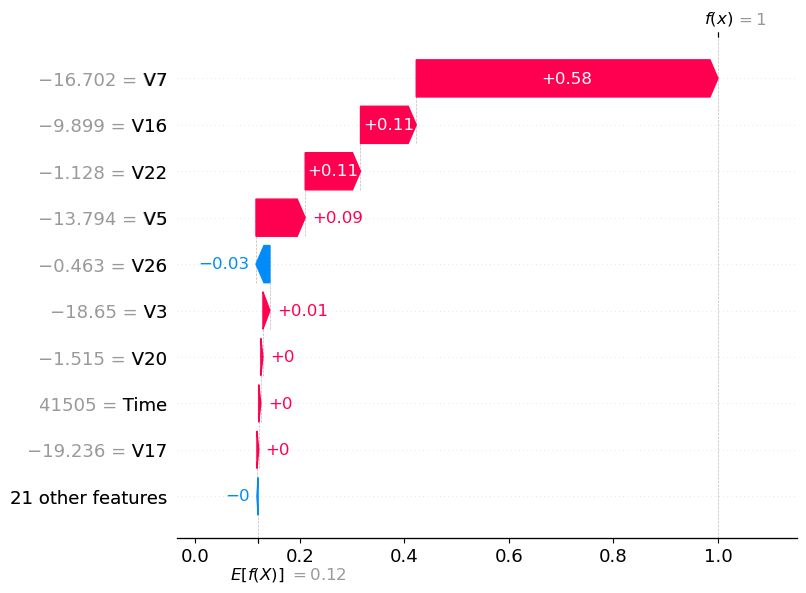

In [35]:
# Plot the SHAP values for the first instance's positive class
shap.plots.waterfall(positive_class_shap_values[0])

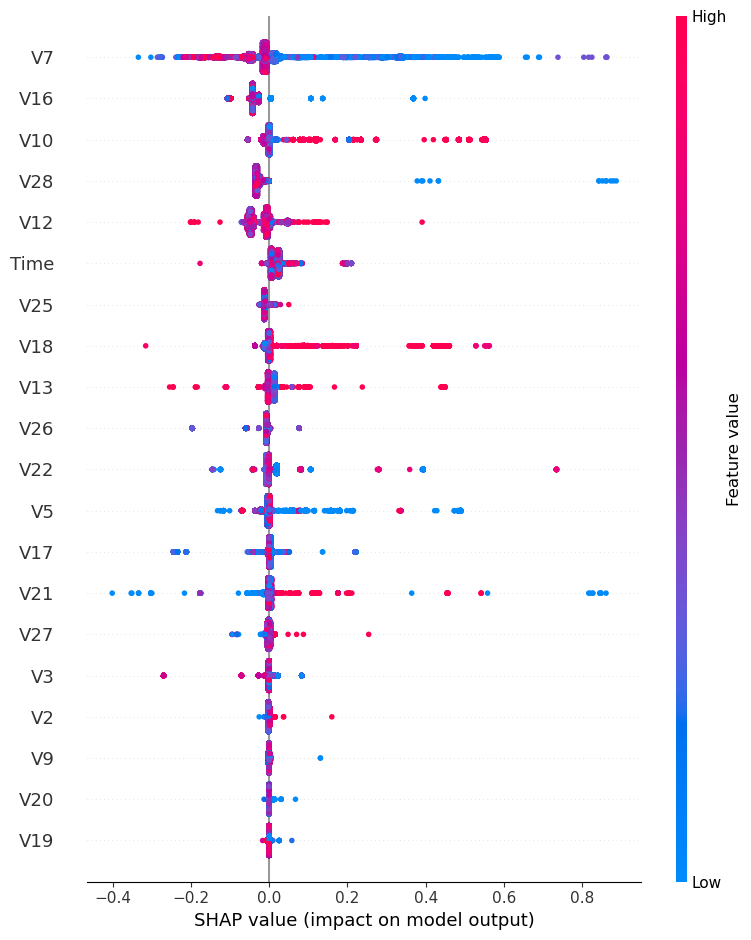

In [36]:
shap.summary_plot(positive_class_shap_values, X_test)